In [1]:
from tensorflow.keras.models import load_model
from tqdm.notebook import tqdm
import mnist
import dnn
import os.path
import graph_tool as gt
import nn2graph
import numpy as np
import pandas as pd
import statsmodels.stats as stats
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt
import seaborn as sns

#### Convert neural network to graph

In [2]:
N = 5000
num_runs = 3
rand_inds = mnist.subsample_test(N)
def get_activation_networks(inputs, run=1, num_layers=4, num_epochs=10):
    from tensorflow.keras.layers import Dense
    model = dnn.load_run(run+1, num_layers=num_layers, num_epochs=num_epochs)
    layer_sizes = [inputs.shape[-1]] + [layer.units for layer in model.layers if isinstance(layer, Dense)]
    _, g_xs = nn2graph.dense_activations_to_graph(model, inputs)
    return g_xs, layer_sizes

def get_layer_sizes(inputs, num_layers=4, num_outputs=10, hidden_dims=64):
    layer_sizes = [inputs[0].shape[-1]]
    for i in range(num_layers):
        layer_sizes.append(hidden_dims)
    layer_sizes.append(num_outputs)
    return layer_sizes

In [9]:
gs, _ = get_activation_networks(mnist.X_test[:10])

#### Mean weighted degree distributions per class

In [3]:
def compute_mean_weighted_degrees(inputs):
    mean_weighted_degrees = []
    for i in tqdm(range(num_runs)):
        g_xs, layer_sizes = get_activation_networks(inputs, run=i)
        mean_weighted_degrees.append([float(g.vp['degree'].a[inputs.shape[-1]:].mean()) for g in g_xs])
        del g_xs
    mean_weighted_degrees = np.array(mean_weighted_degrees).mean(axis=0)
    return mean_weighted_degrees
    
def compute_mean_weighted_degrees_by_layer(inputs):
    mean_weighted_degrees_by_layer = []
    for i in tqdm(range(num_runs)):
        g_xs, layer_sizes = get_activation_networks(inputs, run=i)
        layer_mean_degrees = []
        for i, (l, st) in enumerate(zip(layer_sizes, np.cumsum(layer_sizes))):
            mean_weighted_degrees = [float(g.vp['degree'].a[st-l:st].mean()) for g in g_xs]
            layer_mean_degrees.append(mean_weighted_degrees)
        mean_weighted_degrees_by_layer.append(np.array(layer_mean_degrees))
        del g_xs
    mean_weighted_degrees_by_layer = np.array(mean_weighted_degrees_by_layer).mean(axis=0)
    return mean_weighted_degrees_by_layer

In [ ]:
mean_weighted_degrees = compute_mean_weighted_degrees(mnist.X_test[rand_inds])
mean_weighted_degrees_by_layer = compute_mean_weighted_degrees_by_layer(mnist.X_test[rand_inds])

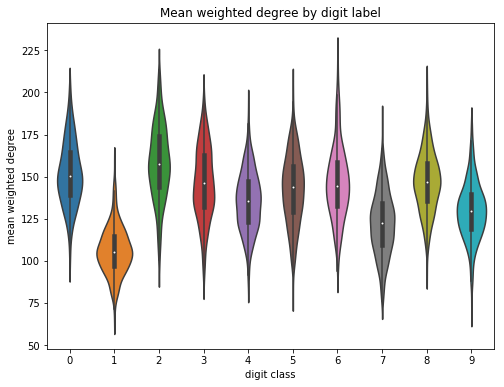

In [5]:
g_xs_mean_degree_by_class = pd.DataFrame({'digit class': mnist.test_labels[rand_inds],
                                          'mean weighted degree': mean_weighted_degrees})
plt.figure(figsize=(8,6))
sns.violinplot(x='digit class', y='mean weighted degree', data=g_xs_mean_degree_by_class)
plt.title('Mean weighted degree by digit label')
plt.show()

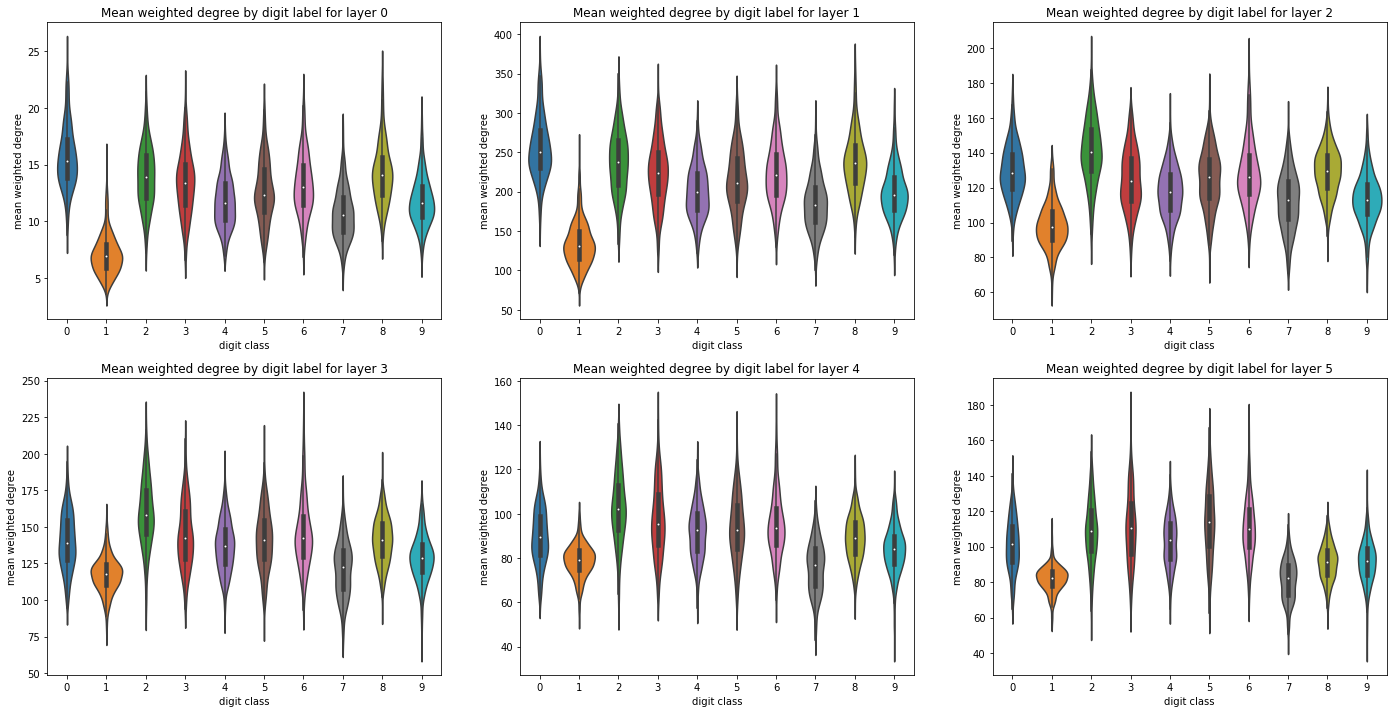

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(3*8,2*6))
for i in range(6):
    ax = axs[0 if i < 3 else 1, i%3]
    g_xs_mean_degree_by_class_ = pd.DataFrame({'digit class': mnist.test_labels[rand_inds],
                                               'mean weighted degree': mean_weighted_degrees_by_layer[i]})
    sns.violinplot(x='digit class', y='mean weighted degree', data=g_xs_mean_degree_by_class_,
                   ax=ax)
    ax.set_title('Mean weighted degree by digit label for layer {}'.format(i))
plt.show()

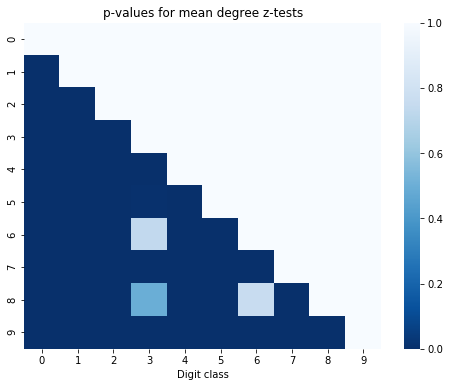

In [7]:
from statsmodels.stats.weightstats import ztest

groups_by_class = g_xs_mean_degree_by_class.groupby('digit class').groups.items()
p_vals = np.ones((10,10))
for i, (c_1, inds_1) in enumerate(groups_by_class):
    for j, (c_2, inds_2) in enumerate(groups_by_class):
        if j >= i:
            continue
        sample_1 = g_xs_mean_degree_by_class.loc[inds_1, 'mean weighted degree']
        sample_2 = g_xs_mean_degree_by_class.loc[inds_2, 'mean weighted degree']
        z, p = ztest(sample_1, sample_2)
        p_vals[i, j] = p
plt.figure(figsize=(8,6))
sns.heatmap(p_vals, cmap='Blues_r')
plt.title('p-values for mean degree z-tests')
plt.xlabel('Digit class')
plt.show()

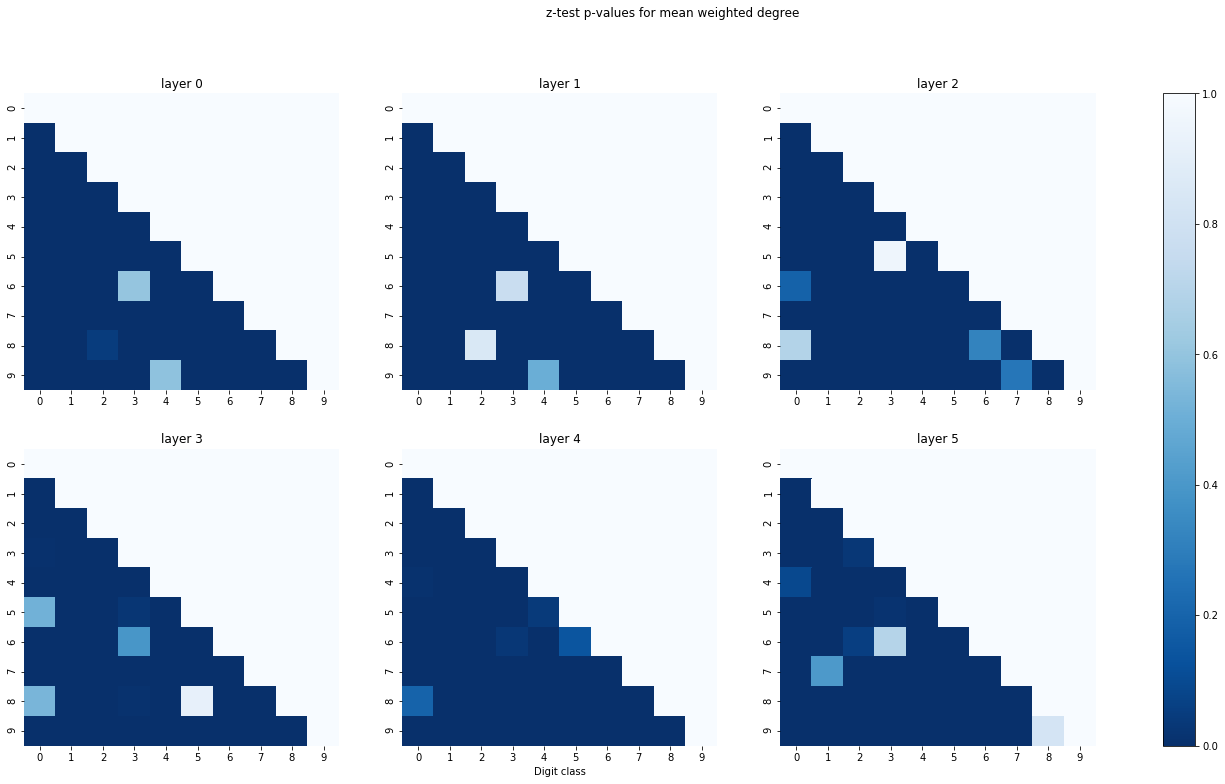

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(3*8,2*6))
for k in range(6):
    ax = axs[0 if k < 3 else 1, k%3]
    g_xs_mean_degree_by_class_l = pd.DataFrame({'digit class': mnist.test_labels[rand_inds],
                                                'mean weighted degree': mean_weighted_degrees_by_layer[k]})
    groups_by_class = g_xs_mean_degree_by_class_l.groupby('digit class').groups.items()
    p_vals = np.ones((10,10))
    for i, (c_1, inds_1) in enumerate(groups_by_class):
        for j, (c_2, inds_2) in enumerate(groups_by_class):
            if j >= i:
                continue
            sample_1 = g_xs_mean_degree_by_class_l.loc[inds_1, 'mean weighted degree']
            sample_2 = g_xs_mean_degree_by_class_l.loc[inds_2, 'mean weighted degree']
            z, p = ztest(sample_1, sample_2)
            p_vals[i, j] = p
    hmap = sns.heatmap(p_vals, cmap='Blues_r', ax=ax, cbar=False)
    ax.set_title('layer {}'.format(k))
    if k == 4:
        ax.set_xlabel('Digit class')
plt.colorbar(hmap.get_children()[0], ax=axs)
plt.suptitle('z-test p-values for mean weighted degree')
plt.show()

#### Mean weighted degrees vs number of active inputs

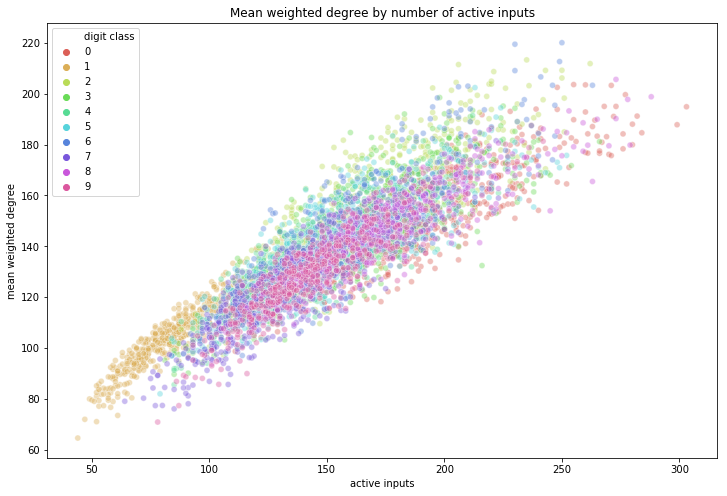

In [9]:
g_xs_degree_by_inputs = pd.DataFrame({'active inputs': np.sum(mnist.X_test[rand_inds], axis=1),
                                      'digit class': mnist.test_labels[rand_inds],
                                      'mean weighted degree': mean_weighted_degrees})
plt.figure(figsize=(12,8))
sns.scatterplot(x='active inputs', y='mean weighted degree', hue='digit class',
                palette=sns.color_palette('hls', 10), alpha=0.4,
                data=g_xs_degree_by_inputs)
plt.title('Mean weighted degree by number of active inputs')
plt.show()

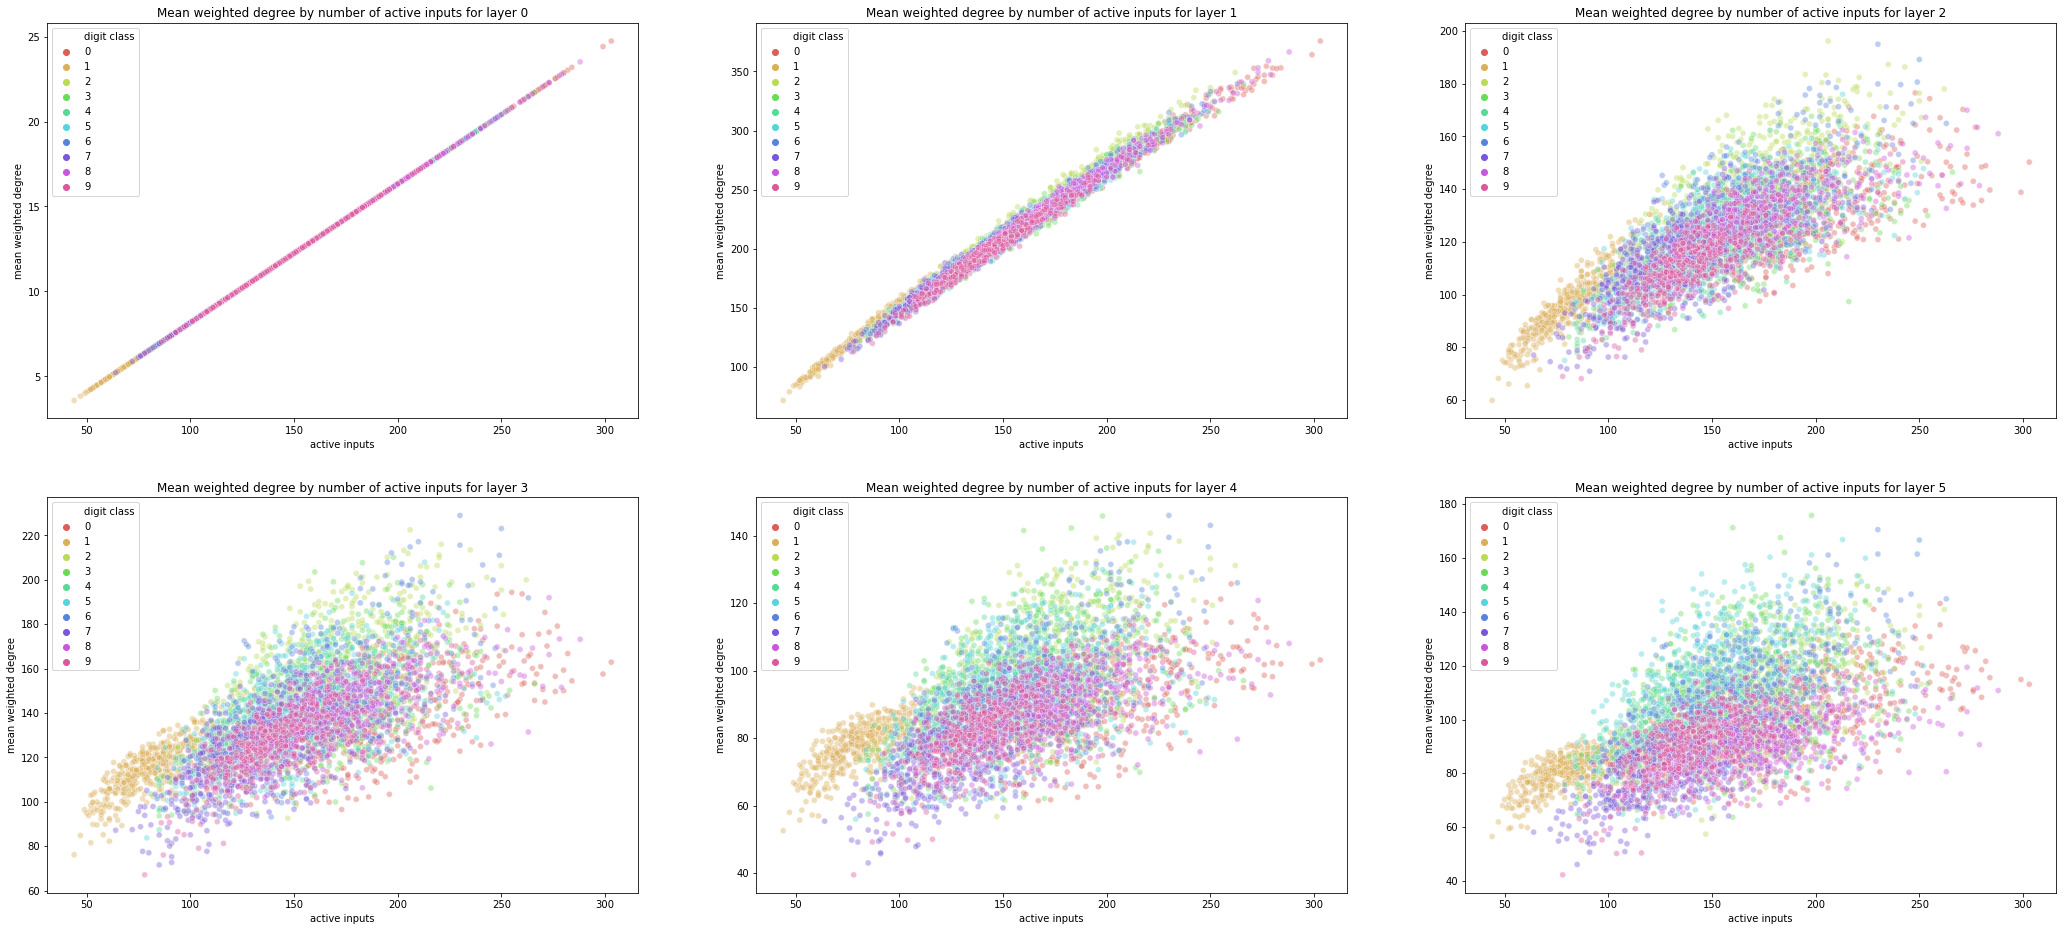

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(3*12,2*8))
for i in range(6):
    ax = axs[0 if i < 3 else 1, i%3]
    g_xs_mean_degree_vs_inputs = pd.DataFrame({'active inputs': np.sum(mnist.X_test[rand_inds], axis=1),
                                               'digit class': mnist.test_labels[rand_inds].flatten(),
                                               'mean weighted degree': mean_weighted_degrees_by_layer[i]})
    sns.scatterplot(x='active inputs', y='mean weighted degree', hue='digit class',
                    palette=sns.color_palette('hls', 10), alpha=0.4,
                    data=g_xs_mean_degree_vs_inputs,
                    ax=ax)
    ax.set_title('Mean weighted degree by number of active inputs for layer {}'.format(i))
plt.show()

In [13]:
from scipy.spatial.distance import pdist, squareform
def deg_pdf(g):
    degs = g.vp['degree'].a
    pdf = degs / np.sum(degs)
    return pdf
N = 1000
g_xs, _ = get_activation_networks(mnist.X_test[rand_inds], run=1, num_layers=4, num_epochs=10)
sub_inds = np.concatenate([np.random.choice(np.where(mnist.test_labels[rand_inds] == c)[0], N // 10, replace=False) for c in range(10)], axis=0)
labels, pdfs = zip(*[(mnist.test_labels[rand_inds[i]], deg_pdf(g_xs[i])) for i in sub_inds])
labels, pdfs = np.array(labels), np.array(pdfs)
js_dists = squareform(pdist(pdfs, metric='jensenshannon'))
avg_dists = np.ones((10,10))
for i in range(10):
    for j in range(10):
        avg_dists[i,j] = np.mean(js_dists[i*100:(i+1)*100,j*100:(j+1)*100])
del g_xs

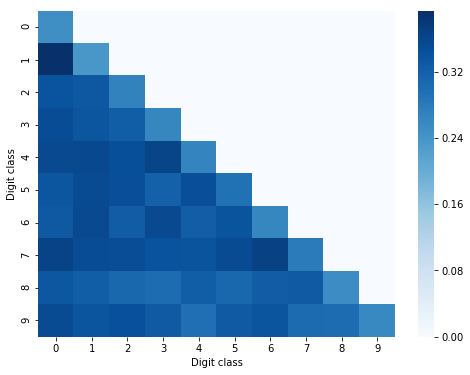

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(avg_dists*np.tril(np.ones((10,10))), cmap='Blues')
#plt.title('Average Jensen-Shannon distance between degree distributions')
plt.xlabel('Digit class')
plt.ylabel('Digit class')
plt.show()

#### Activation rankings

In [41]:
def num_violations(A, pi):
    assert len(pi.shape) <= 2
    pi = np.reshape(pi, (pi.shape[0], 1))
    return np.sum(A * (pi < pi.T), dtype=np.int32)

def mvr(A, patience=None, initial_order=None):
    """
    Runs MVR on graph given by adj matrix A.
    Returns final ranking pi, total number of steps run, and an array of updates [V_i for all steps i]
    """
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    n = A.shape[0]
    # set patience to n choose 2
    patience = n*(n-1) // 2 if patience is None else patience
    inds = np.array(range(n))
    if initial_order is None:
        pi_0 = np.copy(inds)
        np.random.shuffle(pi_0)
    else:
        pi_0 = initial_order
    i = 0
    pi_i = pi_0
    V_i = num_violations(A, pi_i)
    V_all = [V_i]
    last_update = 0
    # repeat while violation count is > 0 and patience threshold not reached
    while V_i > 0 and (i - last_update) < patience:
        i += 1
        # randomly select indices
        k, j = np.random.choice(inds, size=2, replace=False)
        pi_ii = np.copy(pi_i)
        # swap indices in proposed ranking
        pi_ii[[j, k]] = pi_i[[k, j]]
        # compute number of violations
        V_ii = num_violations(A, pi_ii)
        if V_ii < V_i:
            # if number of violations improved, update current ranking
            pi_i, V_i = pi_ii, V_ii
            last_update = i
        print('step {}: {}'.format(i, V_i))
        V_all.append(V_i)
    return pi_i, i, V_all

def compute_activation_counts(inputs, batch_size=100):
    activation_counts = None
    with tqdm(total=num_runs*inputs.shape[0]) as prog:
        for i in range(num_runs):
            for j in range(0, inputs.shape[0], batch_size):
                g_xs, layer_sizes = get_activation_networks(inputs[j:j+batch_size], run=i)
                if activation_counts is None:
                    activation_counts = np.zeros((1, sum(layer_sizes)))
                activation_counts_arr = np.array([(g.vp.activation.a > 0).astype(np.float32) for g in g_xs])
                activation_counts += np.sum(activation_counts_arr, axis=0)
                prog.update(batch_size)
                del g_xs
    return activation_counts

In [5]:
activation_counts = compute_activation_counts(mnist.X_test)

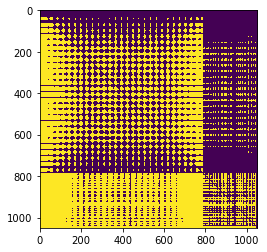

In [7]:
plt.imshow((activation_counts.T > activation_counts).astype(np.float32))

In [48]:
order, i, num_violations = mvr((activation_counts.T > activation_counts).astype(np.float32), patience=1200, initial_order=np.flip(order))

TypeError: 'list' object is not callable

In [47]:
order

array([ 105,   60,   53, ..., 1046, 1045, 1044])

In [81]:
def graph_to_adj_matrix(g):
    from scipy.sparse import dok_matrix
    n = g.num_vertices()
    edge_list = g.get_edges()
    sparse_mat = dok_matrix((n,n), dtype=np.int32)
    for u, v in edge_list:
        sparse_mat[u, v] = 1
    return sparse_mat.todense()

def sort_adj_matrix(node_order, adj_mat):
    R = np.copy(adj_mat)
    idx = np.flipud(np.argsort(node_order))
    R = R[:,idx]
    R = R[idx,:]
    return R

def sort_nodes(node_order, node_names):
    idx = np.flipud(np.argsort(node_order))
    node_names = node_names[idx]
    return node_names

def get_partition_boundaries(partition):
    _, idxs = np.unique(partition,return_index=True)
    return np.sort(idxs)[1:]

def plot_one_boundary(idx,ax,alpha=0.7):
    lims = ax.get_xlim()
    x = [lims[0],lims[1]]
    y = [idx-0.5,idx-0.5]
    ax.plot(x,y,'w',alpha=alpha)
    ax.plot(y,x,'w',alpha=alpha)

def plot_all_boundaries(idxs,ax):
    for idx in idxs:
        plot_one_boundary(idx,ax)

In [82]:
from graph_tool.draw import sfdp_layout, graph_draw
g = gt.Graph(directed=True)
for i in range(len(order)-1):
    g.add_edge(order[i], order[i+1])

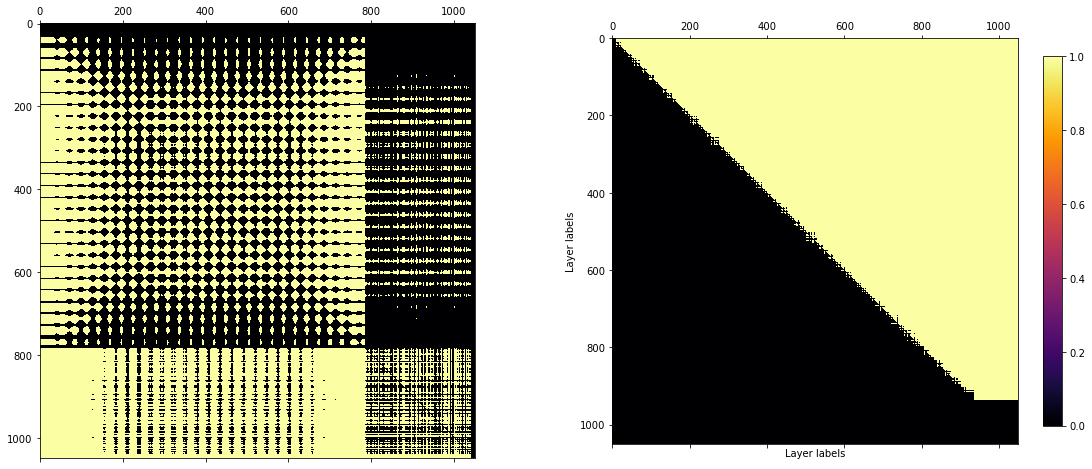

In [90]:
def compress_node_labels(labels):
    compressed_labels = [labels[0]]
    for i in range(1, len(labels)):
        if labels[i] != compressed_labels[-1]:
            compressed_labels.append(labels[i])
    return compressed_labels
g_adj = (activation_counts.T > activation_counts).astype(np.float32)
groups = order
order = np.array(np.argsort(np.argsort(groups)))
g_adj_sorted = sort_adj_matrix(order, g_adj)
node_names = sort_nodes(order, np.array(range(1050)))
ordered_groups = sort_nodes(order, groups)
fig, axs = plt.subplots(1, 2, figsize=(2*10,8))
ax = axs[1]
im = ax.matshow(g_adj_sorted, cmap='inferno')
plt.colorbar(im, ax=ax, shrink=0.85)
node_names_compressed = compress_node_labels(node_names)
plt.xlabel('Layer labels')
plt.ylabel('Layer labels')
plt.title('')
ax = axs[0]
ax.matshow(g_adj, cmap='inferno')
plt.show()

In [57]:
pos_vp = g.new_vp('vector<float>', vals=np.array([for ]))

array([1044, 1045, 1046, ...,   53,   60,  105])